In [1]:
import numpy as np
import sympy as sym
from sympy import symbols, Eq, pprint, init_printing
import scipy.integrate
import matplotlib.pyplot as plt
import tellurium as te
import pandas as pd
from IPython.display import display
sym.init_printing()

/Users/xcyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).



#### Fit Cohesive network rates [PDS5, Wapl, Sororin, unloading]

In [2]:
## Rates for cohesive network 
rates_coh = sym.symbols("K_RacP_RacPW, K_RacPW_RacP, K_RacP_RacPS, K_RacPS_RacP, K_RacP_Rac, K_Rac_RacP, K_Rac_RacN, K_RacN_Rac, K_RacPW_Rac_free")
K_RacP_RacPW, K_RacPW_RacP, K_RacP_RacPS, K_RacPS_RacP, K_RacP_Rac, K_Rac_RacP, K_Rac_RacN, K_RacN_Rac, K_RacPW_Rac_free = rates_coh

paras_coh = sym.symbols("tau_S, F_S, N_S, tau_W, F_W, N_W, tau_P, F_P, N_P, tau_N, F_N, N_N, tau_R, F_R_sister, N_R")
tau_S, F_S, N_S, tau_W, F_W, N_W, tau_P, F_P, N_P, tau_N, F_N, N_N, tau_R, F_R_sister, N_R = paras_coh 

## Equations for cohesive network
rhs_coh = [K_RacPW_Rac_free * N_W * F_W - F_R_sister*N_R/tau_R,                              # RAD21 unbinding  
           F_N/(tau_N * (1-F_N)) - K_Rac_RacN * (F_R_sister * N_R - F_P * N_P - F_N * N_N),  # Nipbl binding
           K_RacN_Rac - 1/tau_N,                                                             # Nipbl unbinding 
           F_W/(tau_W * (1-F_W)) - K_RacP_RacPW * (F_P * N_P - F_S * N_S - F_W * N_W),       # Wapl binding 
           K_RacPW_RacP + K_RacPW_Rac_free - 1/tau_W,                                        # Wapl unbinding  
           F_S/(tau_S * (1-F_S)) - K_RacP_RacPS * (F_P * N_P - F_S * N_S - F_W * N_W),       # Sororin binding
           K_RacPS_RacP - 1/tau_S,                                                           # Sororin unbinding
           F_P/(tau_P * (1-F_P)) - K_Rac_RacP * (F_R_sister * N_R - F_P * N_P - F_N * N_N),                  # PDS5 binding
           K_RacPW_Rac_free * F_W *N_W + K_RacP_Rac*(F_P * N_P - F_S * N_S - F_W * N_W) - F_P * N_P/tau_P,   # PDS5 unbinding  
]

## solutions cohesive network
sol_rates_coh = sym.solve(rhs_coh, rates_coh)

for i, eq in enumerate(rhs_coh, 1):
    pprint(Eq(symbols(f"eq_{i}"), eq))

        F_R_sister⋅N_R                           
eq₁ = - ────────────── + F_W⋅K_RacPW_Rac_free⋅N_W
             τ_R                                 
           F_N                                                        
eq₂ = ───────────── - K_Rac_RacN⋅(-F_N⋅N_N - F_P⋅N_P + F_R_sister⋅N_R)
      τ_N⋅(1 - F_N)                                                   
                    1 
eq₃ = K_RacN_Rac - ───
                   τ_N
           F_W                                                  
eq₄ = ───────────── - K_RacP_RacPW⋅(F_P⋅N_P - F_S⋅N_S - F_W⋅N_W)
      τ_W⋅(1 - F_W)                                             
                                         1 
eq₅ = K_RacPW_RacP + K_RacPW_Rac_free - ───
                                        τ_W
           F_S                                                  
eq₆ = ───────────── - K_RacP_RacPS⋅(F_P⋅N_P - F_S⋅N_S - F_W⋅N_W)
      τ_S⋅(1 - F_S)                                             
                      1 
eq₇ = K_RacPS_RacP - 

In [3]:
## parameters for cohesive network
# Define the input parameters
x = 0.1306   # for W
y = 0.3067  # for P  
z = 0.1536  # for N

paras_values_coh = [
    100.,                  # tau_S
    0.52,                  # F_S
    79770,                 # N_S
    45.,                   # tau_W
    x/(0.65 + x),          # modified F_W for sister 
    69542*(0.65 + x),      # modified N_W for sister
    72,                    # tau_P
    y/(0.58 + y),          # modified F_P for sister
    180615*(0.58 + y),     # modified N_P for sister
    72.,                   # tau_N
    z/(0.6 + z),           # modified F_N for sister
    119308*(0.6 + z),      # modified N_N for sister
    3600 * 20,             # tau_R_sister, 6h 
    1/2,                   # modified F_R_sister
    284470*2/3,            # modified N_R
]

paras_dict_coh = dict(zip(paras_coh, paras_values_coh))

for s in sol_rates_coh.items():
    rate = s[1].evalf(subs=paras_dict_coh)
    paras_dict_coh[s[0]] = rate

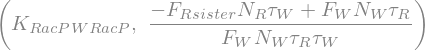

0.0220772140868738


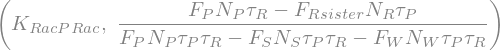

0.158950150555797


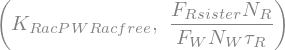

0.000145008135348390


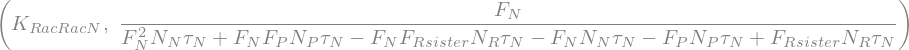

1.68485754442323e-7


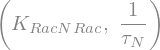

0.0138888888888889


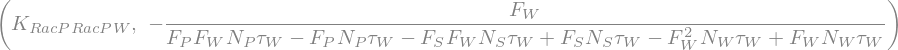

9.24032418587105e-7


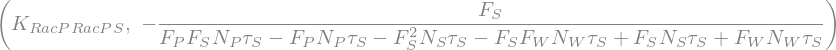

2.24198141378093e-6


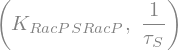

0.0100000000000000


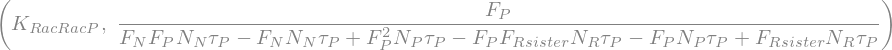

3.48023847571798e-7


In [4]:
## print the rates for the cohesive network
paras_dict_coh = dict(zip(paras_coh, paras_values_coh))
for s in sol_rates_coh.items():
    rate = s[1].evalf(subs=paras_dict_coh)
    paras_dict_coh[s[0]] = rate
    display(s)
    print(rate)

#### Extrusive network [Nipbl, PDS5, Wapl, unloading]

##### assume RPW cobound state, not RW state

In [5]:
## Rates for extrusive network
rates_ext = sym.symbols("Kext_R_free_RN, Kext_RN_R, Kext_R_RN, Kext_R_RP, Kext_RP_R, Kext_RP_RPW, Kext_RPW_RP, Kext_RPW_R_free")
Kext_R_free_RN, Kext_RN_R, Kext_R_RN, Kext_R_RP, Kext_RP_R, Kext_RP_RPW, Kext_RPW_RP, Kext_RPW_R_free = rates_ext

paras_ext = sym.symbols("tau_N_ext, F_N_ext, N_N_ext, tau_W_ext, F_W_ext, N_W_ext, tau_P_ext, F_P_ext, N_P_ext, tau_R_ext, F_R_ext, N_R_ext")
tau_N_ext, F_N_ext, N_N_ext, tau_W_ext, F_W_ext, N_W_ext, tau_P_ext, F_P_ext, N_P_ext, tau_R_ext, F_R_ext, N_R_ext = paras_ext

## Equations for extrusive network
rhs_ext = [ Kext_RN_R - 1 / tau_N_ext,  # NIPBL unbinding kinetics
        Kext_R_free_RN * N_R_ext *(1-F_R_ext) + Kext_R_RN * (N_R_ext*F_R_ext - N_N_ext*F_N_ext - N_P_ext*F_P_ext) -  F_N_ext / tau_N_ext/ (1-F_N_ext), # NIPBL binding equilibrium
        Kext_RP_R * (N_P_ext * F_P_ext - N_W_ext * F_W_ext) + Kext_RPW_R_free * N_W_ext * F_W_ext  - N_P_ext * F_P_ext/tau_P_ext, # PDS5 unbinding kinetics
        Kext_R_RP * (N_R_ext * F_R_ext - N_N_ext * F_N_ext - N_P_ext * F_P_ext)  - F_P_ext / tau_P_ext /(1-F_P_ext), # PDS5 binding equilibrium,
        Kext_RPW_RP + Kext_RPW_R_free - 1 / tau_W_ext, # WAPL unbinding kinetics
        Kext_RP_RPW * (N_P_ext * F_P_ext - N_W_ext* F_W_ext)  - F_W_ext / tau_W_ext / (1-F_W_ext), # WAPL binding equilibrium
        Kext_RPW_R_free * N_W_ext * F_W_ext - F_R_ext * N_R_ext / tau_R_ext,  # RAD21 unbinding kinetics
        Kext_R_free_RN * N_N_ext * (1-F_N_ext) - F_R_ext / tau_R_ext / (1-F_R_ext) # RAD21 binding equilibrium, 
]

sol_rates_ext = sym.solve(rhs_ext, rates_ext)
# Print equations
for i, eq in enumerate(rhs_ext, 1):
    pprint(Eq(symbols(f"eq_{i}"), eq))

                     1   
eq₁ = Kext_RN_R - ───────
                  τ_N_ext
               F_N_ext                                                        
eq₂ = - ───────────────────── + Kext_R_RN⋅(-F_N_ext⋅N_N_ext - F_P_ext⋅N_P_ext 
        τ_N_ext⋅(1 - F_N_ext)                                                 

                                                         
+ F_R_ext⋅N_R_ext) + Kext_R_free_RN⋅N_R_ext⋅(1 - F_R_ext)
                                                         
        F_P_ext⋅N_P_ext                                                       
eq₃ = - ─────────────── + F_W_ext⋅Kext_RPW_R_free⋅N_W_ext + Kext_RP_R⋅(F_P_ext
            τ_P_ext                                                           

                           
⋅N_P_ext - F_W_ext⋅N_W_ext)
                           
               F_P_ext                                                        
eq₄ = - ───────────────────── + Kext_R_RP⋅(-F_N_ext⋅N_N_ext - F_P_ext⋅N_P_ext 
        τ_P_ext⋅(1 - F_P_ext) 

In [6]:
paras_values_ext = [
    72.,                          # tau_N
    (0.4 - z)/(1 - z),            # F_N
    119308*(1 - z),               # N_N
    45.,                          # tau_W
    (0.35 - x)/(1 - x),           # modified F_W for extrusive
    69542*(1 - x),                # modified N_W for extrusive
    72,                           # tau_P
    (0.42 - y)/(1 - y),           # modified F_P for extrusive
    180615*(1 - y),               # modified N_P for extrusive
    822.,                         # tau_R_extrusive
    1/2,                          # modified F_R_sister
    284470*2/3,                   # modified N_R
]

paras_dict_ext = dict(zip(paras_ext, paras_values_ext))

for s in sol_rates_ext.items():
    rate = s[1].evalf(subs=paras_dict_ext)
    paras_dict_ext[s[0]] = rate

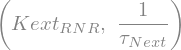

0.0138888888888889


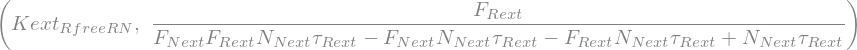

1.69944598876500e-8


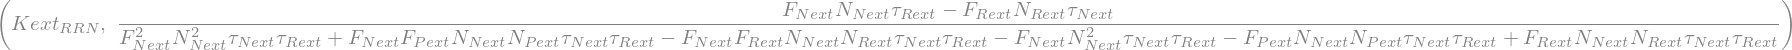

9.10150252853556e-8


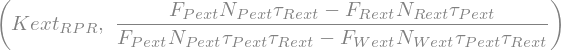

0.0324348013096406


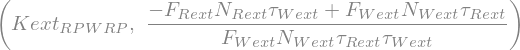

0.0146615640996053


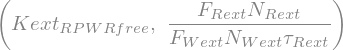

0.00756065812261696


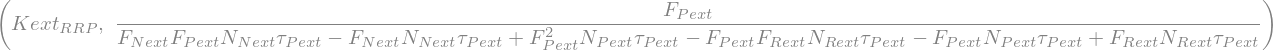

6.03423511339860e-8


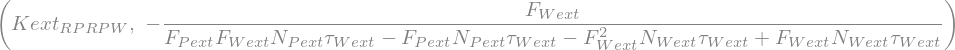

1.44076400442243e-6


In [7]:
### print the rates for the extrusive network
paras_dict_ext = dict(zip(paras_ext, paras_values_ext))
for s in sol_rates_ext.items():
    rate = s[1].evalf(subs=paras_dict_ext)
    paras_dict_ext[s[0]] = rate
    display(s)
    print(rate)

#### Study the combined networks

In [8]:
## models for combined cohesive and extrusive networks
model_ext_coh ='''
    # Define species and parameters
    
    # Cohesive network 
    Rac + N -> RacN; K_Rac_RacN*Rac*N - K_RacN_Rac*RacN
    Rac + P -> RacP; K_Rac_RacP*Rac*P - K_RacP_Rac*RacP
    RacP + S -> RacPS; K_RacP_RacPS*RacP*S - K_RacPS_RacP*RacPS
    RacP + W -> RacPW; K_RacP_RacPW*RacP*W - K_RacPW_RacP*RacPW
    RacPW -> Rac_free + P + W; K_RacPW_Rac_free*RacPW 
    
    # Extrusive network 
    R_free + N -> RN; Kext_R_free_RN*R_free*N 
    RN  -> R + N; Kext_RN_R*RN - Kext_R_RN*R*N
    R + P -> RP; Kext_R_RP*R*P - Kext_RP_R*RP
    RP + W -> RPW; Kext_RP_RPW*RP*W - Kext_RPW_RP*RPW 
    RPW -> R_free + P + W; Kext_RPW_R_free*RPW
    
    # deacetylation
    # Rac_free -> R_free; K_Rac_free_R_free*Rac_free
    
    # Rates for cohesive network,  9 rates
    K_Rac_RacN = {K_Rac_RacN};
    K_RacN_Rac = {K_RacN_Rac};
    K_Rac_RacP = {K_Rac_RacP}; 
    K_RacP_Rac = {K_RacP_Rac}; 
    K_RacP_RacPS = {K_RacP_RacPS}; 
    K_RacPS_RacP = {K_RacPS_RacP}; 
    K_RacP_RacPW = {K_RacP_RacPW}; 
    K_RacPW_RacP = {K_RacPW_RacP};  
    K_RacPW_Rac_free = {K_RacPW_Rac_free}; 

    # Rates for extrusive network, 8 rates
    Kext_R_free_RN = {Kext_R_free_RN};
    Kext_RN_R = {Kext_RN_R};
    Kext_R_RN = {Kext_R_RN};
    Kext_R_RP = {Kext_R_RP};
    Kext_RP_R = {Kext_RP_R};
    Kext_RP_RPW = {Kext_RP_RPW};
    Kext_RPW_RP = {Kext_RPW_RP};
    Kext_RPW_R_free = {Kext_RPW_R_free};

    # K_Rac_free_R_free = {K_Rac_free_R_free}; 
    
    # Initial conditions
    Rac_free = {Rac_free_init}; 
    Rac = {Rac_init}; 
    RacP = {RacP_init}; 
    RacN = {RacN_init}; 
    RacPW = {RacPW_init}; 
    RacPS = {RacPS_init}; 

    R_free = {R_free_init};
    RN = {RN_init};
    R = {R_init};
    RP = {RP_init};
    RPW = {RPW_init};
    
    N = {N_init};
    S = {S_init}; 
    W = {W_init}; 
    P = {P_init};
'''

def build_model_ext_coh(model, parameter_dict):
    string_params = {str(k): v for k, v in parameter_dict.items()}
    return model.format(**string_params)


In [9]:
# Define symbolic initial conditions
Rac_free_init, Rac_init, RacN_init, RacP_init, RacPW_init, RacPS_init, R_free_init, RN_init, R_init, RP_init, RPW_init, N_init, S_init, W_init, P_init = sym.symbols(
    "Rac_free_init, Rac_init, RacN_init, RacP_init, RacPW_init, RacPS_init, R_free_init, RN_init, R_init, RP_init, RPW_init, N_init, S_init, W_init, P_init")

In [10]:
paras_dict_coh

In [11]:
init_conditions_ext_coh_WT = {
    Rac_free_init: 0, 
    Rac_init: paras_dict_coh[N_R]*1/2, 
    RacN_init: 0, 
    RacP_init: 0,
    RacPW_init: 0,
    RacPS_init: 0,

    R_free_init: paras_dict_coh[N_R],
    RN_init: 0,
    R_init: 0,
    RP_init: 0, 
    RPW_init: 0, 
    
    N_init: 119308,
    S_init: paras_dict_coh[N_S],
    W_init: 69542,
    P_init: 180615,
}

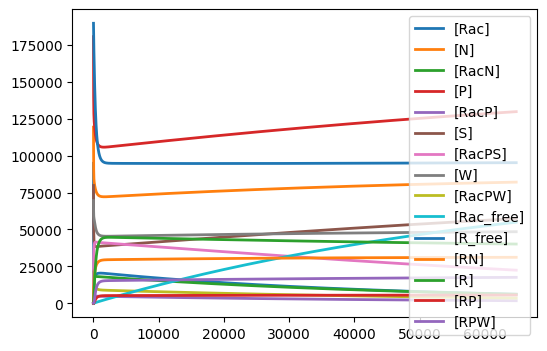

In [12]:
paras_dict_WT = paras_dict_coh | paras_dict_ext | init_conditions_ext_coh_WT | {"K_Rac_free_R_free": 1/2495}
paras_dict_ext_coh_WT = {str(key): value for key, value in paras_dict_WT.items()}
Model_ext_coh_WT = build_model_ext_coh(model_ext_coh, paras_dict_ext_coh_WT)
# print(model_ext_coh)
# Load the modes
r_ext_coh_WT = te.loada(Model_ext_coh_WT)
# Simulate the model
Model_ext_coh_WT = r_ext_coh_WT.simulate(0, 3600*18, 3600*18)
# Plot the simulation results
r_ext_coh_WT.plot()

In [21]:
columns = ['time', 'Rac', 'N', 'RacN', 'P', 'RacP', 'S', 'RacPS', 'W', 'RacPW', 
           'Rac_free', 'R_free', 'RN', 'R', 'RP', 'RPW']
df_WT = pd.DataFrame(Model_ext_coh_WT, columns=columns)
time_8h = 3600 * 8 - 1
depletion_level = 0.99 
remaining_level = 1 - depletion_level
init_conditions_ext_coh_dWapl_8h = {
    Rac_free_init: df_WT['Rac_free'][time_8h], 
    Rac_init: df_WT['Rac'][time_8h], 
    RacN_init: df_WT['RacN'][time_8h], 
    RacP_init: df_WT['RacP'][time_8h] + df_WT['RacPW'][time_8h]*depletion_level,
    RacPW_init: df_WT['RacPW'][time_8h] * remaining_level,
    RacPS_init: df_WT['RacPS'][time_8h],

    R_free_init: df_WT['R_free'][time_8h],
    RN_init: df_WT['RN'][time_8h],
    R_init: df_WT['R'][time_8h],
    RP_init: df_WT['RP'][time_8h] + df_WT['RPW'][time_8h]*depletion_level, 
    RPW_init: df_WT['RPW'][time_8h] * remaining_level,
    
    N_init: df_WT['N'][time_8h],
    S_init: df_WT['S'][time_8h],
    W_init: df_WT['W'][time_8h] * remaining_level,
    P_init: df_WT['P'][time_8h],
}

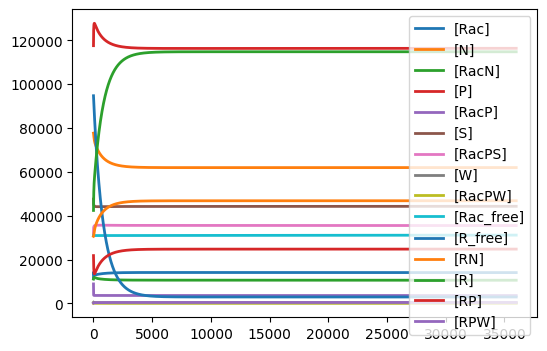

In [16]:
paras_dict_since_8h_dW = paras_dict_coh | paras_dict_ext | init_conditions_ext_coh_dWapl_8h | {"K_Rac_free_R_free": 1/2495}
paras_dict_ext_coh_since_8h_dW = {str(key): value for key, value in paras_dict_since_8h_dW.items()}
Model_ext_coh_since_8h_dW = build_model_ext_coh(model_ext_coh, paras_dict_ext_coh_since_8h_dW)
# print(model_ext_coh)
# Load the modes
r_ext_coh_since_8h_dW = te.loada(Model_ext_coh_since_8h_dW)
# Simulate the model
Model_ext_coh_since_8h_dW = r_ext_coh_since_8h_dW.simulate(0, 3600*10, 3600*10)
# Plot the simulation results
r_ext_coh_since_8h_dW.plot()

In [17]:
columns = ['time', 'Rac', 'N', 'RacN', 'P', 'RacP', 'S', 'RacPS', 'W', 'RacPW', 
           'Rac_free', 'R_free', 'RN', 'R', 'RP', 'RPW']
df_since_8h = pd.DataFrame(Model_ext_coh_since_8h_dW, columns=columns)

for h in range(11):  # 0h to 18h inclusive
    index = 3600 * h - 1  if h > 0 else 0
    # calculate the ratio of bouned sisterC 
    bound_sisterC_ratio = (df_since_8h['Rac'][index] + df_since_8h ['RacN'][index] + df_since_8h ['RacP'][index] + df_since_8h ['RacPW'][index] + df_since_8h ['RacPS'][index]) / (paras_dict_coh[N_R]*0.5)
    bound_sisterC_ratio_f = "{:.4f}".format(bound_sisterC_ratio)
    sisterC_value = int(7765 * bound_sisterC_ratio)
    bound_extC_ratio = (df_since_8h ['R'][index] + df_since_8h ['RN'][index] + df_since_8h ['RP'][index] + df_since_8h ['RPW'][index]) / (paras_dict_coh[N_R]*0.5)
    bound_extC_ratio_f = "{:.4f}".format(bound_extC_ratio)
    extC_bound_frac = (df_since_8h ['R'][index] + df_since_8h ['RN'][index] + df_since_8h ['RP'][index] + df_since_8h ['RPW'][index])/((df_since_8h['R'][index] + df_since_8h['RN'][index] + df_since_8h['RP'][index] + df_since_8h['RPW'][index]) + df_since_8h['R_free'][index])
    extC_value = int(7765 * bound_extC_ratio)
    LEF_sep = 320000*extC_bound_frac/(extC_value/2)
    velocity = (df_since_8h ['R'][index] + df_since_8h ['RN'][index] + df_since_8h ['RP'][index] + df_since_8h ['RPW'][index])/df_since_8h ['RN'][index]/5
    # print(f"{h}h -- {sisterC_value} -- {bound_sisterC_ratio_f}")
    if h==5:
        LEF_sep_5h = int(LEF_sep)
        velocity_5h = velocity
    print(f"{h}h -- {sisterC_value} -- {bound_sisterC_ratio_f} -- {extC_value} -- {bound_extC_ratio_f} -- {extC_bound_frac} -- {LEF_sep} -- {velocity}")

0h -- 5231 -- 0.6737 -- 7773 -- 1.0011 -- 0.5005656000239385 -- 41.21471555581122 -- 0.6208765343355707
1h -- 5229 -- 0.6735 -- 15156 -- 1.9519 -- 0.9759273032374468 -- 41.2109708413807 -- 0.7947755586200068
2h -- 5228 -- 0.6733 -- 15288 -- 1.9689 -- 0.9844637241366798 -- 41.212505458364404 -- 0.7979179027802015
3h -- 5226 -- 0.6731 -- 15291 -- 1.9693 -- 0.9846473496897641 -- 41.21210540850494 -- 0.7979640412063371
4h -- 5224 -- 0.6729 -- 15291 -- 1.9693 -- 0.9846514612311235 -- 41.21227749577654 -- 0.7979437692188749
5h -- 5223 -- 0.6727 -- 15291 -- 1.9693 -- 0.9846517778538416 -- 41.21229074792091 -- 0.797922104778556
6h -- 5221 -- 0.6725 -- 15291 -- 1.9693 -- 0.9846518208402245 -- 41.21229254710246 -- 0.7979003544473837
7h -- 5220 -- 0.6723 -- 15291 -- 1.9693 -- 0.9846520334929788 -- 41.21230144761667 -- 0.7978786803527299
8h -- 5218 -- 0.6721 -- 15291 -- 1.9693 -- 0.9846521545164727 -- 41.212306513016976 -- 0.797856986317826
9h -- 5216 -- 0.6719 -- 15291 -- 1.9693 -- 0.984652310059

In [24]:
time_5h = 3600*5 -1
print("WT 9h")
rate_R_free_to_RN = paras_dict_ext_coh_since_8h_dW['Kext_R_free_RN']*df_since_8h['N'][time_5h]
rate_RPW_R_free = paras_dict_ext_coh_since_8h_dW['Kext_RPW_R_free']
rate_RN_R = paras_dict_ext_coh_since_8h_dW['Kext_RN_R']
rate_R_RN = paras_dict_ext_coh_since_8h_dW['Kext_R_RN']*df_since_8h['N'][time_5h]
rate_R_RP = paras_dict_ext_coh_since_8h_dW['Kext_R_RP']*df_since_8h['P'][time_5h]
rate_RP_R = paras_dict_ext_coh_since_8h_dW['Kext_RP_R']
rate_RP_RPW = paras_dict_ext_coh_since_8h_dW['Kext_RP_RPW']*df_since_8h['W'][time_5h]
rate_RPW_RP = paras_dict_ext_coh_since_8h_dW['Kext_RPW_RP']

print(f"R_free to RN: {rate_R_free_to_RN }")
print(f"RPW to R_free: {rate_RPW_R_free}")
print(f"RN to R: {rate_RN_R}")
print(f"R to RN: {rate_R_RN}")
print(f"R to RP: {rate_R_RP}")
print(f"RP to R: {rate_RP_R }")
print(f"RP to RPW: {rate_RP_RPW}")
print(f"RPW to RP: {rate_RPW_RP}")

WT 9h
R_free to RN: 0.00105253356534639
RPW to R_free: 0.00756065812261696
RN to R: 0.0138888888888889
R to RN: 0.00563691754236347
R to RP: 0.00701872669261465
RP to R: 0.0324348013096406
RP to RPW: 0.000363916952673177
RPW to RP: 0.0146615640996053


### Sister RAD21 residence time

In [ ]:
def sister_RAD21_bound_time(K_RacPW_Rac_free, B_W_sister, B_R_sister):
    # K_RPW_R_free * N_W * F_W - F_R_sister*N_R/tau_R
    ### F_R is the fraction of bounded RAD21, T_W is the total number of bounded Wapl 
    return B_R_sister/(K_RacPW_Rac_free * B_W_sister)


time_5h = 3600*5 - 1

sister_RAD21_time_5h = sister_RAD21_bound_time(
        K_RacPW_Rac_free = paras_dict_ext_coh_since_8h_dW['K_RacPW_Rac_free'], \
        B_W_sister = df_since_8h['RacPW'][time_5h], \
        B_R_sister = df_since_8h['RacPS'][time_5h] \
            + df_since_8h['RacPW'][time_5h] \
            + df_since_8h['RacP'][time_5h] \
            + df_since_8h['Rac'][time_5h]  \
            + df_since_8h['RacN'][time_5h] )
print(sister_RAD21_time_5h)



11691054.0235280


In [29]:
import json
with open("extrusion_dict_RN_RB_RP_RW_HBD_dW.json", "r") as f:
    params = json.load(f)
params

{'CTCF_facestall': {'A': 1.0},
 'CTCF_backstall': {'A': 0},
 'CTCF_on_rate': {'A': 0.0233},
 'CTCF_off_rate': {'A': 0.01},
 'LEF_on_rate': {'A': 0.00110280871525382},
 'LEF_off_rate': {'A': 0.00756065812261696},
 'LEF_stalled_off_rate': {'A': 0.00756065812261696},
 'LEF_diffusion_rate': {'A': 0},
 'LEF_pause': {'A': 0},
 'LEF_states': {'RN': 1, 'RB': 2, 'RP': 3, 'RW': 4},
 'LEF_transition_rates': {'21': {'A': 0.00590616964394835},
  '23': {'A': 0.00755343010326287},
  '12': {'A': 0.0138888888888889},
  '32': {'A': 0.0324348013096406},
  '34': {'A': 0.000360096250269467},
  '43': {'A': 0.0146615640996053}},
 'LEF_separation': 41,
 'mode': 'symmetric',
 'sites_per_monomer': 1,
 'monomers_per_replica': 32000,
 'num_of_sisters': 776,
 'sister_lifetime': 6447148,
 'sister_damping': 10,
 'number_of_replica': 1,
 'steps': 65000,
 'dummy_steps': 0,
 'velocity_multiplier': 0.7784183409615875}

In [30]:
params["LEF_on_rate"]["A"] = float(rate_R_free_to_RN)
params["LEF_off_rate"]["A"] = float(rate_RPW_R_free)
params["LEF_stalled_off_rate"]["A"] = float(rate_RPW_R_free)
params["LEF_transition_rates"]["21"]["A"] = float(rate_R_RN)
params["LEF_transition_rates"]["23"]["A"] = float(rate_R_RP)
params["LEF_transition_rates"]["12"]["A"] = float(rate_RN_R)
params["LEF_transition_rates"]["32"]["A"] = float(rate_RP_R)
params["LEF_transition_rates"]["34"]["A"] = float(rate_RP_RPW)
params["LEF_transition_rates"]["43"]["A"] = float(rate_RPW_RP)
params["LEF_separation"] = LEF_sep_5h
params["velocity_multiplier"] = float(velocity_5h)

In [33]:
params['monomers_per_replica'] = 32000
params['num_of_sisters'] = 776
params['sister_damping'] = 100
params['sister_lifetime'] = int(sister_RAD21_time_5h)

In [34]:
with open("extrusion_dict_RN_RB_RP_RW_HBD_dW.json", "w") as f:
    json.dump(params, f, indent=4)